In [3]:
import time
import pandas as pd
import numpy as np
import scipy.stats as stats
import csep
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat')
comcat_count = comcat.get_number_of_events()
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))


Fetched Comcat catalog in 6.319675922393799 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-06-28 02:33:55.456000+00:00
Min Latitude: 31.597166061401367 and Max Latitude: 41.83566665649414
Min Longitude: -125.38899993896484 and Max Longitude: -113.107666015625
Min Magnitude: 2.5 and Max Magnitude: 6.300000190734863



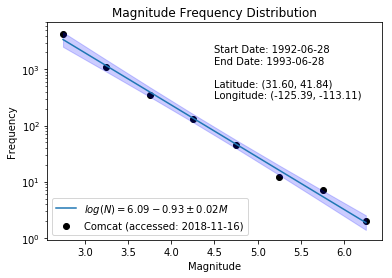

In [5]:
# getting comcat catalog as dataframe 
dm = 0.5
min_mw, max_mw = comcat.min_magnitude, comcat.max_magnitude
mw_inter = arange(min_mw, max_mw+dm, dm)

# switching into dataframe for easy manipulations
df = comcat.get_dataframe()

# bind to comcat catalog
comcat.mfd = pd.DataFrame(df['counts'].groupby(pd.cut(df['magnitude'], mw_inter)).sum())

# perform least-squares to get b-value
# log(N) = a-bM
# N = 10^a / 10^bM
idx = array(comcat.mfd.index.categories.mid)
G = vstack([ones(len(idx)), idx]).T
N = log10(squeeze(comcat.mfd.values))
a, b = linalg.lstsq(G, N, rcond=None)[0]

# generate line to plot
N_est = a + b*idx

# setup vars for plotting ci
p_value = 0.05
err = N - squeeze(N_est)

t_stat = stats.t.ppf(1-p_value/2, len(idx)-2)
mean_x = mean(idx)
n = len(idx)
se_line = sqrt(sum(power(err,2))/(n-2))
se_xk = sqrt(1/n+power(idx-mean_x,2)/sum(power(idx-mean_x,2)))
confs = se_line * se_xk
lower = N_est-t_stat*confs
upper = N_est+t_stat*confs

# confidence interval of b-value
rms = sqrt(mean(power(err,2)))
denom = sum(power(idx-mean_x,2))
ci_b = t_stat*rms/denom
               
# plotting
fig, ax = subplots()
ax.scatter(comcat.mfd.index.categories.mid, comcat.mfd['counts'], color='black', label='{} (accessed: {})'
              .format(comcat.name, comcat.date_accessed.date()))
ax.plot(idx, 10**N_est, label='$log(N)={}-{}\pm{}M$'.format(round(a,2),round(abs(b),2), round(abs(ci_b),2)))
ax.fill_between(idx, 10**lower, 10**upper, color='blue', alpha=0.2)
ax.set_yscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Frequency')
ax.set_title('Magnitude Frequency Distribution')
ax.annotate(s='Start Date: {}\nEnd Date: {}\n\nLatitude: ({:.2f}, {:.2f})\nLongitude: ({:.2f}, {:.2f})'
            .format(comcat.start_time.date(), comcat.end_time.date(),
                   comcat.min_latitude,comcat.max_latitude,
                   comcat.min_longitude,comcat.max_longitude),
            xycoords='axes fraction', xy=(0.5, 0.65), fontsize=10)
ax.legend(loc='lower left')
savefig('comcat_mfd.pdf')